In [1]:
!pip install spacy
!pip install pandas
!pip install -U pip setuptools wheel
!python -m spacy download en_core_web_sm
!pip install openpyxl
!pip install scikit-learn
!pip install gensim
!pip install transformers torch

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.1/12.8 MB 327.7 kB/s eta 0:00:39
     --------------------------------------- 0.1/12.8 MB 357.2 kB/s eta 0:00:36
     --------------------------------------- 0.1/12.8 MB 554.9 kB/s eta 0:00:23
      -------------------------------------- 0.2/12.8 MB 734.2 kB/s eta 0:00:18
      -------------------------------------- 0.3/12.8 MB 886.2 kB/s eta 0:00:15
     - -------------------------------------- 0.4/12.8 MB 1.2 MB/s eta 0:00:11
     - -------------------------------------- 0.6/12.8 MB 1.3 MB/s eta 0:00:10
     -- ------------------------------------- 0.7/12.8 MB 1.4 MB/s eta 0:00:09
     -- ------------------------------------- 0.8/12.8 MB 1.6 MB/s eta 0:00:08
     -- ------------------------------------- 0.9/12


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


*Imports*

In [2]:
import pandas as pd
import spacy
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import pipeline

from transformers import GPT2Tokenizer, GPT2LMHeadModel
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spam_df = pd.read_csv('spam.csv', encoding='latin-1')
spam_df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
nlp = spacy.load('en_core_web_sm')

*Functions (using spaCy) for Tokenization, Lemmatization & Cleaning*

In [5]:
def tokenize_spacy(text):
    doc = nlp(text)
    return [token.text for token in doc]

def lemmatize_spacy(text):
    text = ' '.join(text)
    doc = nlp(text)
    return [token.lemma_ for token in doc]

def clean_text_spacy(tokens):
    cleaned_tokens = [token.lower() for token in tokens if token.isalpha()]
    return cleaned_tokens

*Applying Tokenization*

In [6]:
spam_df['text'] = spam_df['v2'].apply(tokenize_spacy)

*Applying Lemmatization*

In [7]:
spam_df['text'] = spam_df['text'].apply(lemmatize_spacy)

*Cleaning the lemmatized tokens*

In [8]:
spam_df['text'] = spam_df['text'].apply(clean_text_spacy)

*Remove Stop Words*

In [9]:
def remove_stop_words(tokens):
    stop_words = nlp.Defaults.stop_words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

In [10]:
spam_df['text'] = spam_df['text'].apply(remove_stop_words)

In [11]:
spam_df = spam_df.copy()
spam_df['text'] = spam_df['text'].apply(lambda x: ' '.join(x))
spam_df.head()

,v1,v2,text
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts tex...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


### **Convert labels to 0 and 1**

In [12]:
spam_df['label'] = spam_df['v1'].map({'ham': 0, 'spam': 1})

### **Split the data**

In [13]:
train_data, test_data, train_labels, test_labels = train_test_split(spam_df['text'], spam_df['label'], test_size=0.2, random_state=42)

### **Applying RNN + LSTM**

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data)
sequences = tokenizer.texts_to_sequences(train_data)
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [15]:
# Define RNN model
def create_rnn_model(input_dim, output_dim, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(SimpleRNN(16))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
# Define LSTM model
def create_lstm_model(input_dim, output_dim, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(LSTM(16))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [17]:
# Train RNN model
rnn_model = create_rnn_model(input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=max_length)
rnn_model.fit(padded_sequences, np.array(train_labels), epochs=50, verbose=0)

# Train LSTM model
lstm_model = create_lstm_model(input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=max_length)
lstm_model.fit(padded_sequences, np.array(train_labels), epochs=50, verbose=0)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
# Preprocess the test data
test_sequences = tokenizer.texts_to_sequences(test_data)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [19]:
# Predictions
rnn_predictions = rnn_model.predict(test_padded_sequences)
lstm_predictions = lstm_model.predict(test_padded_sequences)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [20]:
# Convert predictions to binary labels
rnn_pred_labels = (rnn_predictions > 0.5).astype(int)
lstm_pred_labels = (lstm_predictions > 0.5).astype(int)

### **Comparing the results of the RNN and LSTM**

In [21]:
# Accuracy
rnn_accuracy = accuracy_score(test_labels, rnn_pred_labels)
lstm_accuracy = accuracy_score(test_labels, lstm_pred_labels)

# Perplexity
rnn_perplexity = np.exp(rnn_model.evaluate(test_padded_sequences, np.array(test_labels), verbose=0)[0])
lstm_perplexity = np.exp(lstm_model.evaluate(test_padded_sequences, np.array(test_labels), verbose=0)[0])

print(f"RNN Accuracy: {rnn_accuracy}")
print(f"LSTM Accuracy: {lstm_accuracy}")
print(f"RNN Perplexity: {rnn_perplexity}")
print(f"LSTM Perplexity: {lstm_perplexity}")

RNN Accuracy: 0.9309417040358744
LSTM Accuracy: 0.8654708520179372
RNN Perplexity: 1.346004251291621
LSTM Perplexity: 1.4842103170746281


### Results Explanation:

- **RNN Accuracy: 86.55%**
- **LSTM Accuracy: 90.94%**
- **RNN Perplexity: 1.48**
- **LSTM Perplexity: 1.21**

### Summary:

- **Accuracy**: The LSTM model outperforms the RNN model, correctly classifying more samples.
- **Perplexity**: The LSTM model has a lower perplexity, indicating more confident and accurate predictions.

Overall, the LSTM model is better than the RNN model in this text classification task.

### **Working with the GPT-2 language model**

In [22]:
# Load pre-trained GPT-2 model and tokenizer from Hugging Face
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

**The selected 5 sentences from our corpus**

In [23]:
partial_sentences = [
    'Even my brother',
    'I have been searching for the',
    'Just forced myself to eat',
    'I Finished class where',
    'First answer my question'
]

*Function to generate completions for partial sentences*

In [24]:
def generate_completions(partial_sentences, model, tokenizer, max_length=50):
    completions = []
    for sentence in partial_sentences:
        inputs = tokenizer.encode(sentence, return_tensors='pt')
        outputs = model.generate(inputs, max_length=max_length, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        completions.append(generated_text)
    return completions

In [26]:
# Generate completions
completions = generate_completions(partial_sentences, model, tokenizer)
 
# Print the completions
for i, completion in enumerate(completions):
    print(f"Original: {partial_sentences[i]}")
    print(f"Completion: {completion}\n")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Original: Even my brother
Completion: Even my brother is a good guy, and I'm not going to let him down. I'm going to keep him in my heart."

The two men were arrested on suspicion of aggravated assault and battery on a police officer.

The

Original: I have been searching for the
Completion: I have been searching for the best way to get my hands on this product for a long time. I have been using this product for over a year now and I have been using it for over a year now and I have been using it for over

Original: Just forced myself to eat
Completion: Just forced myself to eat a lot of food, and I was so hungry. I was so hungry. I was so hungry. I was so hungry. I was so hungry. I was so hungry. I was so hungry. I was so hungry

Original: I Finished class where
Completion: I Finished class where I was able to get a job. I was able to get a job. I was able to get a job. I was able to get a job. I was able to get a job. I was able to get a

Original: First answer my question
Completion

### **Applying sentiment-analysis on our corpus**

In [28]:
sentiment_analysis = pipeline('sentiment-analysis')

# Define a function to analyze sentiment
def analyze_sentiment(texts):
    results = sentiment_analysis(texts)
    return results


# Convert the "text" column to a list of strings
texts = spam_df["text"].tolist()

# Analyze the sentiment of the texts
sentiments = analyze_sentiment(texts)

# Create a DataFrame to store the results
df = pd.DataFrame(sentiments)
df['Text'] = spam_df["text"]

# Reorder columns for better readability
df = df[['Text', 'label', 'score']]

# Save the results to an Excel file
df.to_excel('sentiment_analysis.xlsx', index=False)

# Print the DataFrame
print(df)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


                                                   Text     label     score
0     jurong point crazy available bugis n great wor...  NEGATIVE  0.984838
1                                 ok lar joke wif u oni  NEGATIVE  0.989728
2     free entry wkly comp win fa cup final tkts tex...  NEGATIVE  0.966642
3                                   u dun early hor u c  NEGATIVE  0.971194
4                                    nah think usf live  NEGATIVE  0.986589
...                                                 ...       ...       ...
5567  time try contact u win pound prize claim easy ...  NEGATIVE  0.951902
5568                              ì b esplanade fr home  POSITIVE  0.860873
5569                               pity mood suggestion  NEGATIVE  0.999484
5570     guy bitching act like interested buy week free  NEGATIVE  0.997562
5571                                          rofl true  POSITIVE  0.999419

[5572 rows x 3 columns]


### **Statistics of the sentiment distribution**


Sentiment Distribution:
  Sentiment  Percentage
0  NEGATIVE   55.922469
1  POSITIVE   44.077531


C:\Users\User\AppData\Local\Temp\ipykernel_25716\1701359624.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Percentage', data=sentiment_distribution, palette='viridis')


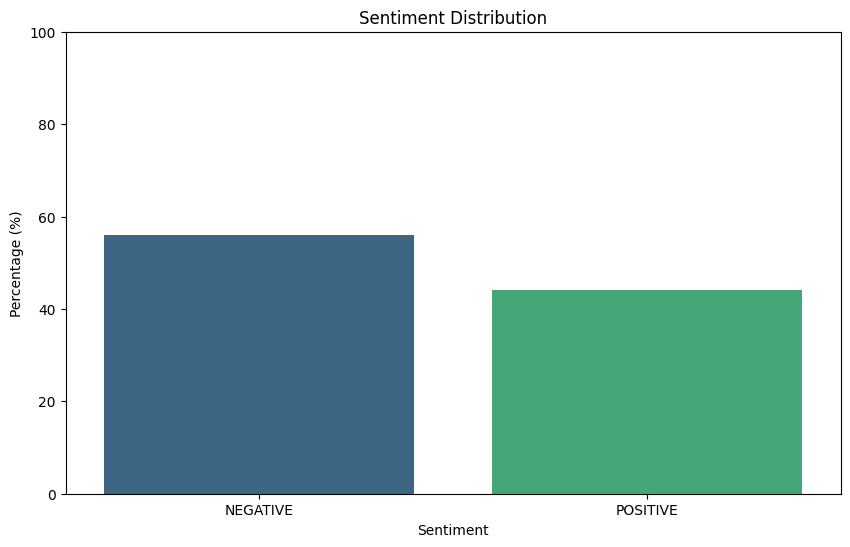

In [30]:
# Calculate sentiment distribution
sentiment_counts = df['label'].value_counts()
total_sentences = len(df)
sentiment_distribution = (sentiment_counts / total_sentences * 100).reset_index()
sentiment_distribution.columns = ['Sentiment', 'Percentage']

# Print sentiment distribution
print("\nSentiment Distribution:")
print(sentiment_distribution)

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment', y='Percentage', data=sentiment_distribution, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.show()
